<a href="https://colab.research.google.com/github/PANDASANG1231/522_Ramen/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/Colab Notebooks/deeplearning_note')

Mounted at /content/drive


In [160]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc


def evaluate_performance(all_target, predicted, toplot=True,silent=True):
    all_target = np.array(all_target)
    predicted = np.array(predicted)
    fpr, tpr, thresholds = roc_curve(all_target, predicted)
    roc_auc = auc(fpr, tpr)
    ks = max(tpr-fpr)
    maxind = (tpr-fpr).argmax()

    event_rate = sum(all_target) / 1.0 / all_target.shape[0]
    cum_total = tpr * event_rate + fpr * (1-event_rate)
    minind, = np.nonzero(np.ravel(abs(cum_total - event_rate) == min(abs(cum_total - event_rate))))
    if minind.shape[0] > 0:
        minind = minind[0]

    if toplot:
        # KS plot
        plt.figure(figsize=(26,6))
        plt.subplot(1,4,1)
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], color='k', linestyle='--', linewidth=2)
        plt.title('KS='+str(round(ks,3))+ ' AUC='+str(round(roc_auc,3)), fontsize=20)
        plt.plot([fpr[maxind], fpr[maxind]], [fpr[maxind], tpr[maxind]], linewidth=4, color='r')
        plt.plot([fpr[minind]], [tpr[minind]], 'k.', markersize=10)

        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel('False positive', fontsize=20); plt.ylabel('True positive', fontsize=20);
        if not silent:
            print ('KS=' + str(round(ks,3)) + ', AUC=' + str(round(roc_auc,3)) +', N='+str(predicted.shape[0]))
            print ('At threshold=' + str(round(event_rate, 3)) + ', TPR=' + str(round(tpr[minind],3)) + ', ' + str(int(round(tpr[minind]*event_rate*all_target.shape[0]))) + ' out of ' + str(int(round(event_rate*all_target.shape[0]))) ) 
            print ('At threshold=' + str(round(event_rate, 3)) + ', TPR=' + str(round(fpr[minind],3)) + ', ' + str(int(round(fpr[minind]*(1.0-event_rate)*all_target.shape[0]))) + ' out of ' + str(int(round((1.0-event_rate)*all_target.shape[0]))))  
    
        # Score distribution score
        plt.subplot(1,4,2)
        #print predicted.columns
        plt.hist(predicted, bins=20)
        plt.axvline(x=np.mean(predicted), linestyle='--')
        plt.axvline(x=np.mean(all_target), linestyle='--', color='g')
        plt.title('N='+str(all_target.shape[0])+' Tru='+str(round(np.mean(all_target),3))+' Pred='+str(round(np.mean(predicted),3)), fontsize=20)
        plt.xlabel('Target rate', fontsize=20)
        plt.ylabel('Count', fontsize=20)

        # Score average by percentile
        binnum = 10
        ave_predict = np.zeros((binnum))
        ave_target = np.zeros((binnum))
        indices = np.argsort(predicted)
        binsize = int(round(predicted.shape[0]/1.0/binnum))
        for i in range(binnum):
            startind = i*binsize
            endind = min(predicted.shape[0], (i+1)*binsize)
            ave_predict[i] = np.mean(predicted[indices[startind:endind]])
            ave_target[i] = np.mean(all_target[indices[startind:endind]])
        
        plt.subplot(1,4,3)
        plt.plot(ave_predict, 'b.-', label='Prediction', markersize=5)
        plt.plot(ave_target, 'r.-', label='Truth', markersize=5)
        plt.legend(loc='lower right')
        plt.xlabel('Percentile', fontsize=20)
        plt.ylabel('Target rate', fontsize=20)
        plt.title("Sloping", fontsize=20)
        if not silent:
            print ('Ave_target: ' + str([round(i,4) for i in ave_target]))
            print ('Ave_predicted: ' + str(ave_predict))
            
            
        count_predict = np.zeros((binnum+1))
        count_target = np.zeros((binnum+1))
        indices = np.argsort(predicted,)
        binsize = int(round(predicted.shape[0]/1.0/binnum))
        for i in range(binnum+1):
            endind = min(predicted.shape[0], (i)*binsize)
            count_predict[i] = np.sum(all_target)-np.sum(all_target[indices[0:endind]])
            count_target[i] = np.sum(all_target)
        
        count_predict = list(count_predict)
        count_predict.reverse()
        ave_predict = list((count_predict/count_target))

        top_20_len = int(len(predicted)/5)
        top_20_ratio = np.sum(all_target[indices[-top_20_len:]])*100.0/np.sum(all_target)
        
        btm_10_len = int(len(predicted)/10)
        btm_10_ratio = np.sum(all_target[indices[:btm_10_len]])*100.0/np.sum(all_target)
        
        plt.subplot(1,4,4)
        plt.plot(ave_predict, 'b.-', markersize=5)
        plt.legend(loc='up right')
        plt.xlabel('Top score bin(bad-->good)', fontsize=20)
        plt.ylabel('Capture rate', fontsize=20)
        plt.title("TOP20:{0}% , BTM10:{1}%".format(round(top_20_ratio,2),round(btm_10_ratio,2)), fontsize=20)
        if not silent:
            print ('#True: ' + str([int(i) for i in count_predict]))
            print ('%True: ' + str([round(i,2) for i in ave_predict]))            
            
        
        plt.show()

    return ks

def show_model_performance_cv(model,lst_df,target='target',list_feature=[],K=3):
    df_fi = pd.DataFrame({'var':list_feature})
    for i,clf in enumerate(model):
        df_fi['fi{}'.format(i)] = clf.feature_importances_
        for df_tmp in lst_df:
            df_tmp['score_{}'.format(i)] = clf.predict_proba(df_tmp[list_feature])[:,1]
    for df_tmp in lst_df:
        df_tmp['model_score'] = df_tmp[['score_{}'.format(i) for i in range(K)]].apply(np.mean,axis=1)
        evaluate_performance(df_tmp[target],df_tmp['model_score'])

    df_fi['fi_total'] = df_fi[['fi{}'.format(i) for i in range(K)]].apply(np.sum,axis=1)
    df_fi.sort_values('fi_total',ascending=False).reset_index(drop=True)
    return df_fi

def cat_series_2_map(cat_series,tail_count=500):

    group_count = cat_series.groupby(cat_series).count().sort_values()
    num = len(cat_series)
    tail_num  = 0.01 * num
    group_2_id = dict()
    i = 2
    for group, count in group_count.iteritems():
        if (count  <= tail_num) & (count <= tail_count):
            group_2_id[group] = 1
        else:
            group_2_id[group] = i
        i += 1
    return group_2_id

def preprocess_categorical(df,cag_vars,tail_count=500):
    dict_categorical_vars_map = {}
    for var in cag_vars:
        dict_categorical_vars_map[var] = cat_series_2_map(df[var],tail_count)
    return dict_categorical_vars_map


def get_df_feature_importance(model):
    df_fi = pd.DataFrame({
        "var":model.feature_name()
        ,"split":model.feature_importance()
       ,"gain":model.feature_importance('gain')})
    df_fi = df_fi.sort_values(by='gain',ascending=False).reset_index(drop=True)
    df_fi['gain'] = df_fi['gain'].apply(lambda x :round(x,1))
    return df_fi[['var','gain','split']]      


def train_cv(train_raw,K=3,list_feature =[],lst_var_cat = [] ,target='target',bst_params={},random_state=1):
    cv_model = []
    train = train_raw.reset_index(drop=True)
    kfold = KFold(n_splits=K, shuffle = True, random_state = random_state)
    
    for idx_train, idx_test in kfold.split(train.index.values):
        X_train, y_train = train[list_feature].loc[idx_train], train[target].loc[idx_train]
        X_test,  y_test  = train[list_feature].loc[idx_test] , train[target].loc[idx_test]
        gbm = lgb.LGBMClassifier(
                                 **bst_params
                                )
        gbm.fit(X_train, y_train,
                eval_set=[(X_train, y_train),(X_test, y_test),#(df_oot_cat2int[list_feature],df_oot_cat2int[target])
                         ],
                eval_metric='auc',
                categorical_feature=lst_var_cat,
                early_stopping_rounds=50,
                verbose=20
               )   
        cv_model.append(gbm)
    return cv_model


  

## LightGBM without w2v

In [161]:
train_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/train_df_afprocess.csv")
test_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/test_df_afprocess.csv")

## Preprocess the target
def handle_target(x, thresh=3.5):
    
    if x < thresh:
        return 1
    else:
        return 0
    
train_data["Stars"] = train_data["Stars"].replace("Unrated", -1).astype(float).apply(handle_target)
test_data["Stars"] = test_data["Stars"].replace("Unrated", -1).astype(float).apply(handle_target)

## Process categorical variables
list_feature = ['Review #', 'Brand', 'Variety', 'Style', 'Top Ten','code']
lst_var_cat = ['Brand', 'Variety', 'Style', 'Top Ten','code']

mapping_dict = preprocess_categorical(train_data, lst_var_cat, tail_count=20)

for key in mapping_dict:
    train_data[key] = train_data[key].map(mapping_dict[key])
    test_data[key] = test_data[key].map(mapping_dict[key])

In [162]:
params_ = {
    'task': 'train',
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'AUC',
    'num_leaves': 4,
    'min_data_in_leaf':100,
    'max_bin':256,
    'max_cat_group':16,
    'cat_smooth_ratio':0.05,
    'min_gain_to_split':0.1,
    'n_estimators':1000,
    'seed': 446
    }


models = train_cv(train_data,K=5,list_feature = list_feature, lst_var_cat = lst_var_cat ,target='Stars',bst_params=params_, random_state=100)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'Variety', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'Variety', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'Variety', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.757981	valid_1's auc: 0.758392
[40]	training's auc: 0.77002	valid_1's auc: 0.766877
[60]	training's auc: 0.780215	valid_1's auc: 0.767763
[80]	training's auc: 0.787992	valid_1's auc: 0.761345
[100]	training's auc: 0.794066	valid_1's auc: 0.761708
Early stopping, best iteration is:
[50]	training's auc: 0.774917	valid_1's auc: 0.769683
Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.765399	valid_1's auc: 0.744347
[40]	training's auc: 0.774668	valid_1's auc: 0.748613
[60]	training's auc: 0.786494	valid_1's auc: 0.752938
[80]	training's auc: 0.794198	valid_1's auc: 0.75264
[100]	training's auc: 0.799947	valid_1's auc: 0.749239
[120]	training's auc: 0.805769	valid_1's auc: 0.750313
Early stopping, best iteration is:
[74]	training's auc: 0.79161	valid_1's auc: 0.754743
Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.769268	valid_1's au

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'Variety', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'Variety', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


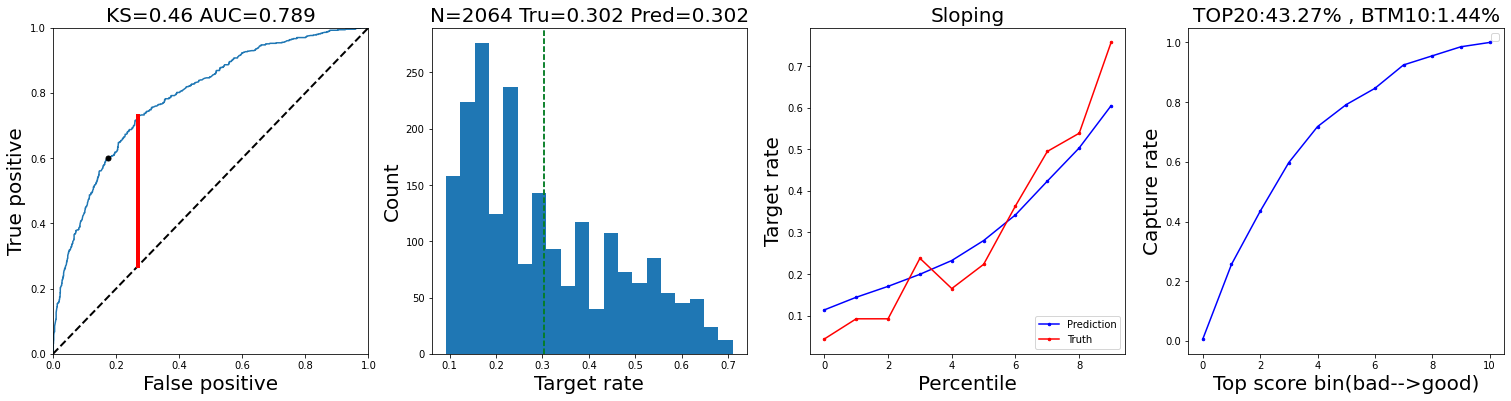

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


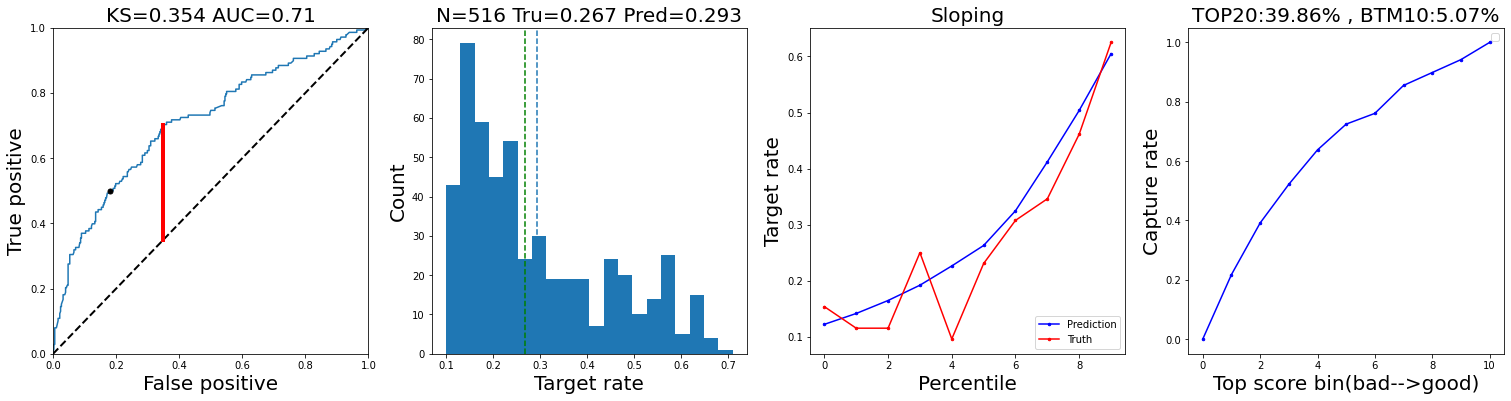

,var,fi0,fi1,fi2,fi3,fi4,fi_total
0,Review #,51,86,71,267,6,481
1,Brand,36,44,37,113,3,233
2,Variety,0,0,0,0,0,0
3,Style,12,19,14,21,1,67
4,Top Ten,0,0,0,0,0,0
5,code,51,73,61,142,8,335


In [163]:
show_model_performance_cv(models,[train_data, test_data],target="Stars",list_feature=list_feature,K=5)

## LightGBM with w2v


In [164]:
train_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/train_df_afprocess.csv")
test_data = pd.read_csv("./drive/MyDrive/Colab Notebooks/test_df_afprocess.csv")


## Preprocess the target
def handle_target(x, thresh=3.5):
    
    if x < thresh:
        return 1
    else:
        return 0
    
train_data["Stars"] = train_data["Stars"].replace("Unrated", -1).astype(float).apply(handle_target)
test_data["Stars"] = test_data["Stars"].replace("Unrated", -1).astype(float).apply(handle_target)

## Process categorical variables
list_feature = ['Review #', 'Brand', 'Style', 'Top Ten','code']
lst_var_cat = ['Brand', 'Style', 'Top Ten','code']

mapping_dict = preprocess_categorical(train_data, lst_var_cat, tail_count=20)

for key in mapping_dict:
    train_data[key] = train_data[key].map(mapping_dict[key])
    test_data[key] = test_data[key].map(mapping_dict[key])

In [165]:
import re
from gensim.models import word2vec 

## Training Part
sentences = []
vector_size = 10
for sent in train_data["Variety"]:
    sentences.append(re.sub('[^a-zA-Z]', ' ', sent.lower().strip()).split())

train_w2v = word2vec.Word2Vec(sentences, size=vector_size, workers=2)
train_w2v.init_sims(replace=True)


def gen_sentence_vec(text, model=train_w2v):
    vec = np.zeros(vector_size)
    count = 0
    for word in re.sub('[^a-zA-Z]', ' ', text.lower().strip()).split():

        try:
            vec += model.wv[word]
            count += 1
        except:
            pass
        
    return (vec/max(count, 1))

rst_train = train_data["Variety"].apply(gen_sentence_vec)
rst_test = test_data["Variety"].apply(gen_sentence_vec)
for i in range(vector_size):
    train_data[f"sent_vec{i}"] = rst_train.apply(lambda x:x[i])
    test_data[f"sent_vec{i}"] = rst_test.apply(lambda x:x[i])
    list_feature += [f"sent_vec{i}"]


X = train_data[[x for x in train_data.columns if x.startswith("sent_vec")]].values
clustering = KMeans(random_state=5, n_clusters=5).fit(X)

train_data["vec_cluster_id"] = clustering.predict(X)
test_data["vec_cluster_id"] = clustering.predict(test_data[[x for x in test_data if x.startswith("sent_vec")]].values)

list_feature += ["vec_cluster_id"]

In [166]:
params_ = {
    'task': 'train',
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'AUC',
    'num_leaves': 4,
    'min_data_in_leaf':100,
    'max_bin':256,
    'max_cat_group':16,
    'cat_smooth_ratio':0.05,
    'min_gain_to_split':0.15,
    'n_estimators':1000,
    'seed': 446
    }


models = train_cv(train_data,K=5,list_feature = list_feature, lst_var_cat = lst_var_cat ,target='Stars',bst_params=params_, random_state=100)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.764278	valid_1's auc: 0.768059
[40]	training's auc: 0.790023	valid_1's auc: 0.778464
[60]	training's auc: 0.808907	valid_1's auc: 0.780102
[80]	training's auc: 0.821421	valid_1's auc: 0.778612
[100]	training's auc: 0.834551	valid_1's auc: 0.778142
[120]	training's auc: 0.844547	valid_1's auc: 0.775591
Early stopping, best iteration is:
[73]	training's auc: 0.817016	valid_1's auc: 0.780411
Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.775241	valid_1's auc: 0.751298
[40]	training's auc: 0.794503	valid_1's auc: 0.757786
[60]	training's auc: 0.811211	valid_1's auc: 0.757368
[80]	training's auc: 0.823741	valid_1's auc: 0.757816
[100]	training's auc: 0.83651	valid_1's auc: 0.755698
Early stopping, best iteration is:
[67]	training's auc: 0.815658	valid_1's auc: 0.759248


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'Style', 'Top Ten', 'code']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.785225	valid_1's auc: 0.72608
[40]	training's auc: 0.808662	valid_1's auc: 0.725333
[60]	training's auc: 0.824509	valid_1's auc: 0.724477
Early stopping, best iteration is:
[19]	training's auc: 0.784637	valid_1's auc: 0.72907
Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.782138	valid_1's auc: 0.701741
[40]	training's auc: 0.802147	valid_1's auc: 0.711152
[60]	training's auc: 0.821025	valid_1's auc: 0.715372
[80]	training's auc: 0.83361	valid_1's auc: 0.718929
[100]	training's auc: 0.845557	valid_1's auc: 0.718159
[120]	training's auc: 0.856517	valid_1's auc: 0.718319
Early stopping, best iteration is:
[83]	training's auc: 0.834227	valid_1's auc: 0.721637
Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.770697	valid_1's auc: 0.763776
[40]	training's auc: 0.795462	valid_1's auc: 0.765483
Early stopping, best iteration is:
[6]	trai

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


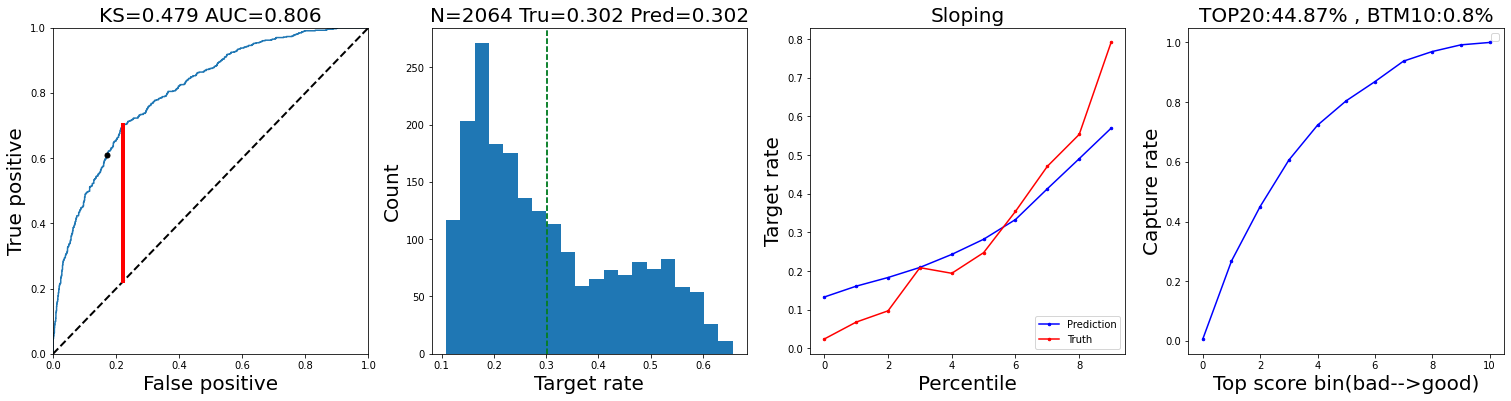

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: MatplotlibDeprecationWarning: Unrecognized location 'up right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


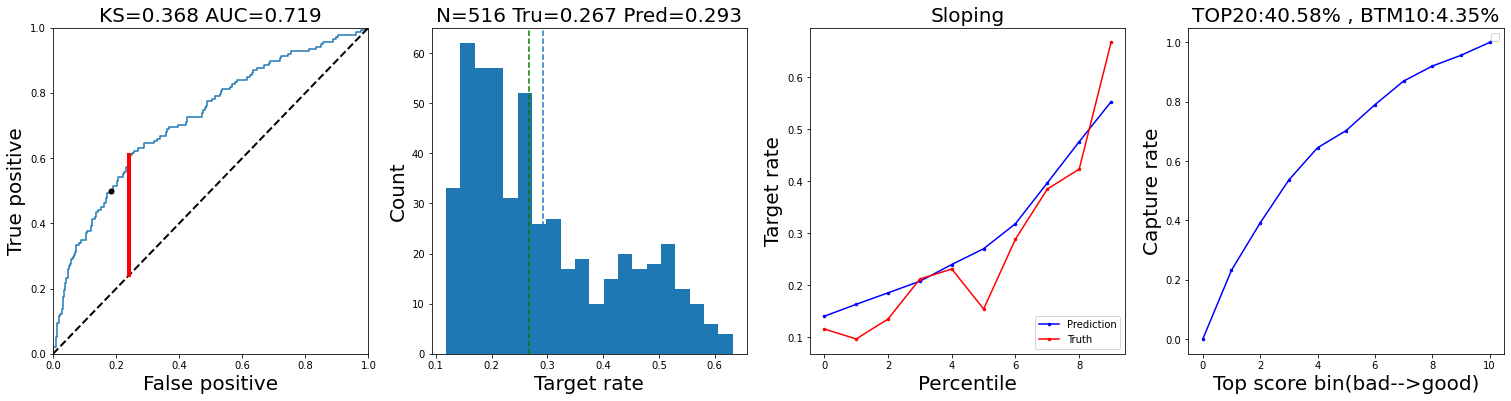

,var,fi0,fi1,fi2,fi3,fi4,fi_total
0,Review #,37,45,16,36,6,140
1,Brand,32,22,10,33,3,100
2,Style,8,7,0,4,0,19
3,Top Ten,0,0,0,0,0,0
4,code,42,44,21,53,8,168
5,sent_vec0,1,3,0,7,0,11
6,sent_vec1,17,5,0,19,0,41
7,sent_vec2,16,11,1,12,0,40
8,sent_vec3,10,18,2,22,1,53
9,sent_vec4,5,4,0,5,0,14


In [167]:
show_model_performance_cv(models,[train_data, test_data],target="Stars",list_feature=list_feature,K=5)